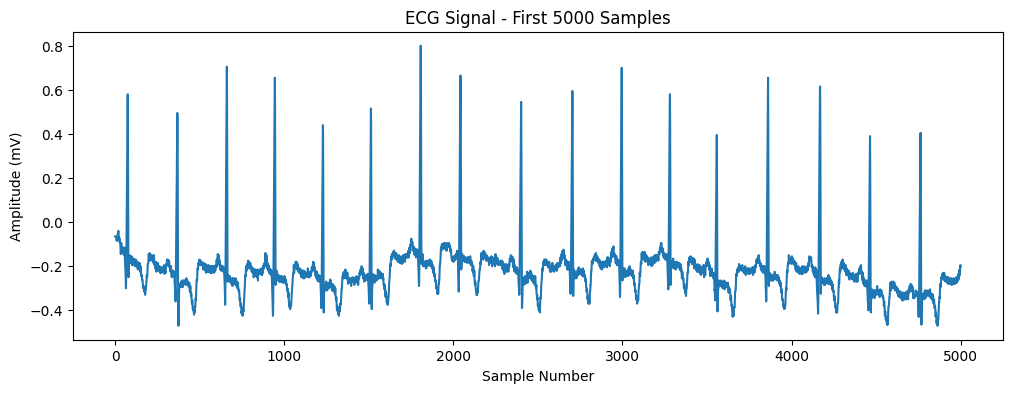

In [12]:
import wfdb
import matplotlib.pyplot as plt

# Replace '100' with the correct base filename if it's different
record_path = '/content/100'

# Read the record and the corresponding annotation if needed
record = wfdb.rdrecord(record_path)
# If you need annotations, use:
# annotation = wfdb.rdann(record_path, 'atr')

# Extract the signal
ecg_signal = record.p_signal[:,1]  # Assuming the second channel is the ECG signal
fs = record.fs  # Sampling frequency

plt.figure(figsize=(12, 4))
plt.plot(ecg_signal[:5000])  # Plot the first 5000 samples
plt.title('ECG Signal - First 5000 Samples')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude (mV)')
plt.show()

In [16]:
import numpy as np
import scipy.signal as signal
import pywt
import matplotlib.pyplot as plt

# Step 1: Baseline Wander Removal using High-pass Filter
# Baseline wander has a low frequency (typically below 0.5 Hz), so a high-pass
# filter effectively removes this drift while retaining the higher frequency
# components that represent the actual cardiac activity.

def remove_baseline_wander(ecg_signal, fs, cutoff=0.5):
    b, a = signal.butter(1, cutoff / (0.5 * fs), btype='highpass')
    return signal.filtfilt(b, a, ecg_signal)

ecg_signal_bw_removed = remove_baseline_wander(ecg_signal, fs)


In [17]:
# Step 2: Filtering
# ECG signals contain important components primarily below 40 Hz, so by
# filtering out higher frequencies, you can reduce noise without affecting the
# diagnostic information in the ECG. This improves the signal quality and
# makes it easier to detect key features like QRS complexes and P-T waves.


# 2a: Low-pass filter to remove high-frequency noise
def low_pass_filter(ecg_signal, fs, cutoff=40):
    b, a = signal.butter(4, cutoff / (0.5 * fs), btype='low')
    return signal.filtfilt(b, a, ecg_signal)

ecg_signal_filtered = low_pass_filter(ecg_signal_bw_removed, fs)

# 2b: Notch filter to remove powerline interference at 50 or 60 Hz
def notch_filter(ecg_signal, fs, notch_freq=50, quality_factor=30):
    b, a = signal.iirnotch(notch_freq / (0.5 * fs), quality_factor)
    return signal.filtfilt(b, a, ecg_signal)

ecg_signal_filtered = notch_filter(ecg_signal_filtered, fs)

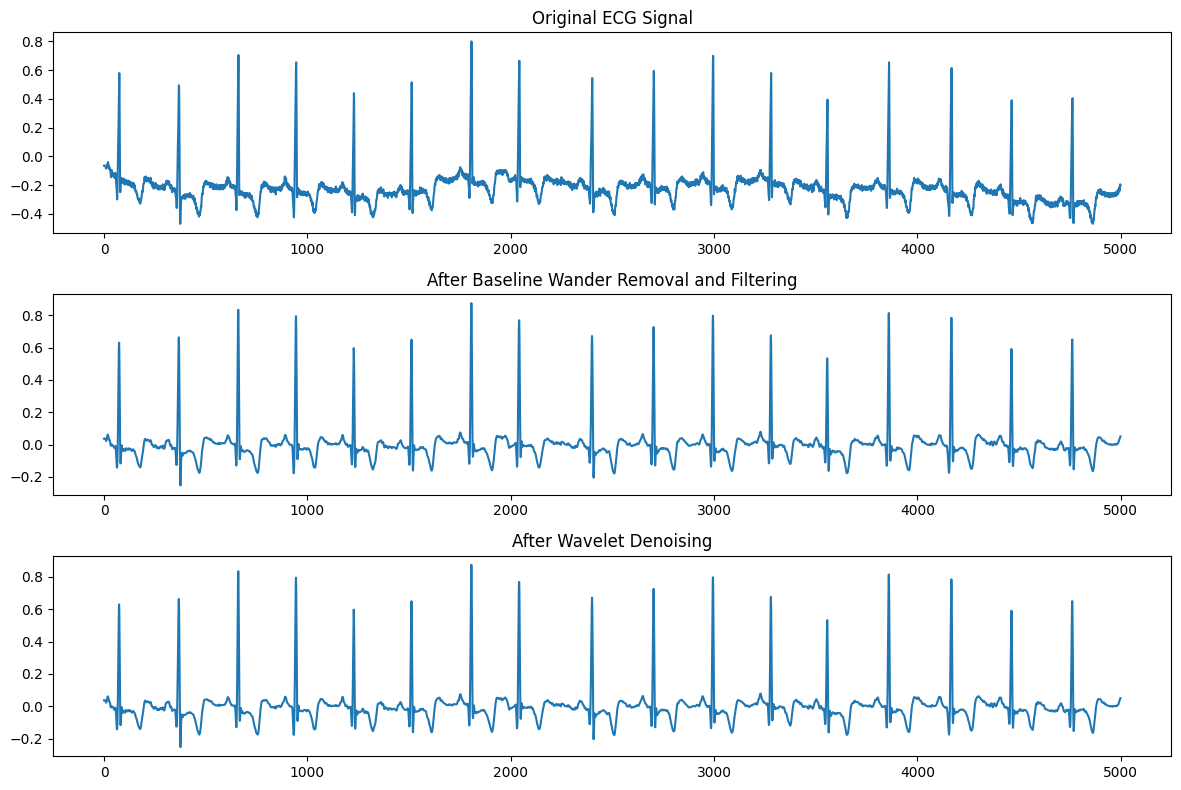

In [19]:
# Step 3: Denoising using Wavelet Transform
# Wavelet Denoising involves decomposing the ECG signal into different frequency
# components using wavelets, then selectively reducing noise by thresholding
# the wavelet coefficients, and finally reconstructing the signal.
# Wavelet denoising is particularly effective for signals like ECG because it can
# target noise at specific scales (frequencies) without affecting the signal’s
# main components. It’s adaptive and can handle non-stationary signals,
# which is a common characteristic of physiological data.

def wavelet_denoising(ecg_signal, wavelet='db6', level=3):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Estimating noise level
    uthresh = sigma * np.sqrt(2 * np.log(len(ecg_signal)))
    denoised_coeffs = list(map(lambda x: pywt.threshold(x, uthresh, mode='soft'), coeffs))
    return pywt.waverec(denoised_coeffs, wavelet)

ecg_signal_denoised = wavelet_denoising(ecg_signal_filtered)

# Plotting the original and processed signals
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.title('Original ECG Signal')
plt.plot(ecg_signal[:5000])
plt.subplot(3, 1, 2)
plt.title('After Baseline Wander Removal and Filtering')
plt.plot(ecg_signal_filtered[:5000])
plt.subplot(3, 1, 3)
plt.title('After Wavelet Denoising')
plt.plot(ecg_signal_denoised[:5000])
plt.tight_layout()
plt.show()
